In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

In [2]:
x1 = np.linspace(0, 10, 12)
x2 = np.linspace(0, 10, 12)
xx, yy = np.meshgrid(x1, x2)
X = np.column_stack([xx.flatten(), yy.flatten()])

## Isotropic samples

### A single group

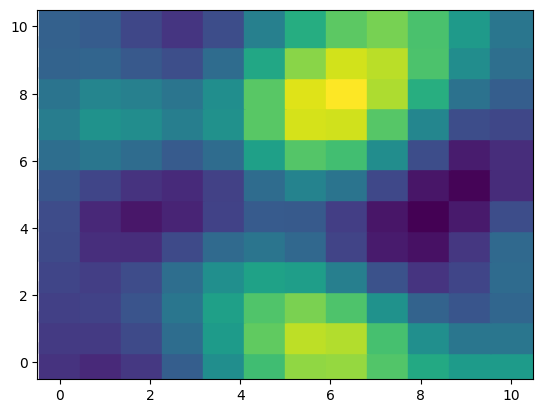

In [3]:
rng = np.random.default_rng(1234)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots()
ax.scatter(xx, yy, c=f, s=900, marker="s");

In [4]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 144
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


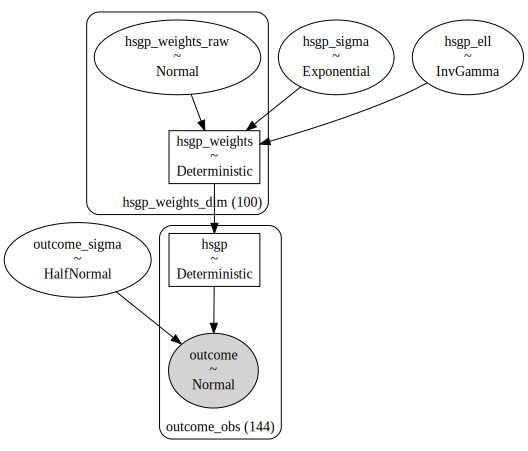

In [5]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10)": "hsgp"})
print(model)
model.build()
model.graph()

In [6]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:02.534947
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:28.089563
Transforming variables...
Transformation time =  0:00:00.551090
0


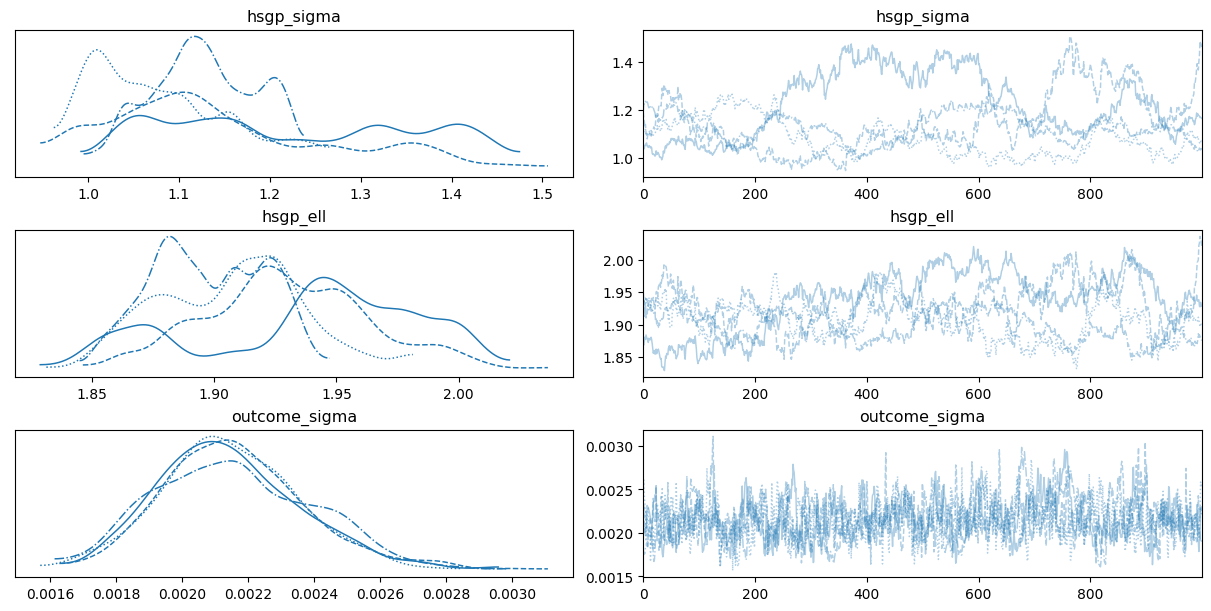

In [7]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - same covariance function

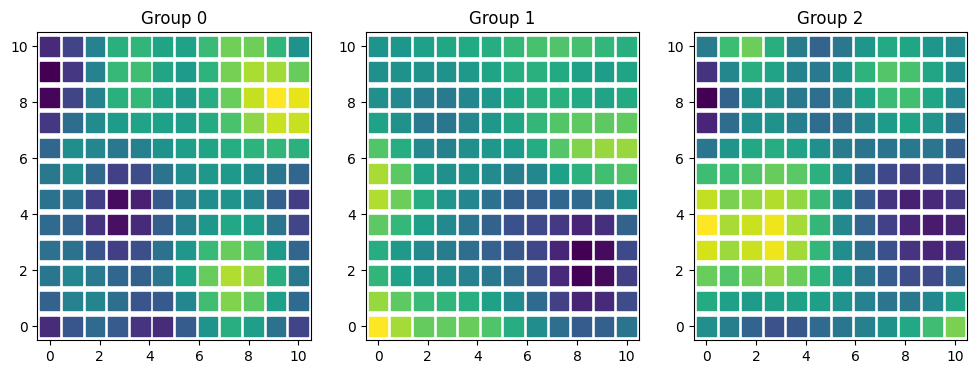

In [8]:
rng = np.random.default_rng(123)

ell = 2
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [9]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


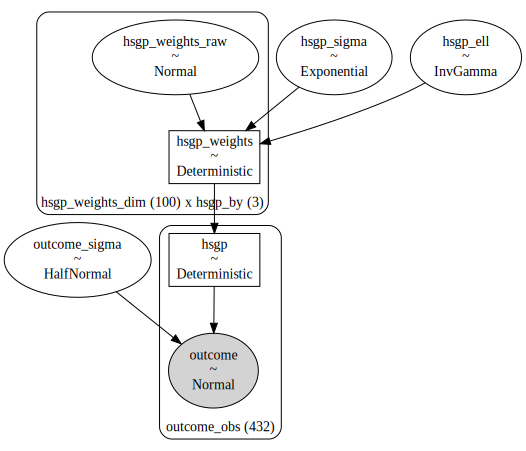

In [10]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10)": "hsgp"})
print(model)
model.build()
model.graph()

In [11]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.901780
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:57.213380
Transforming variables...
Transformation time =  0:00:00.687064
0


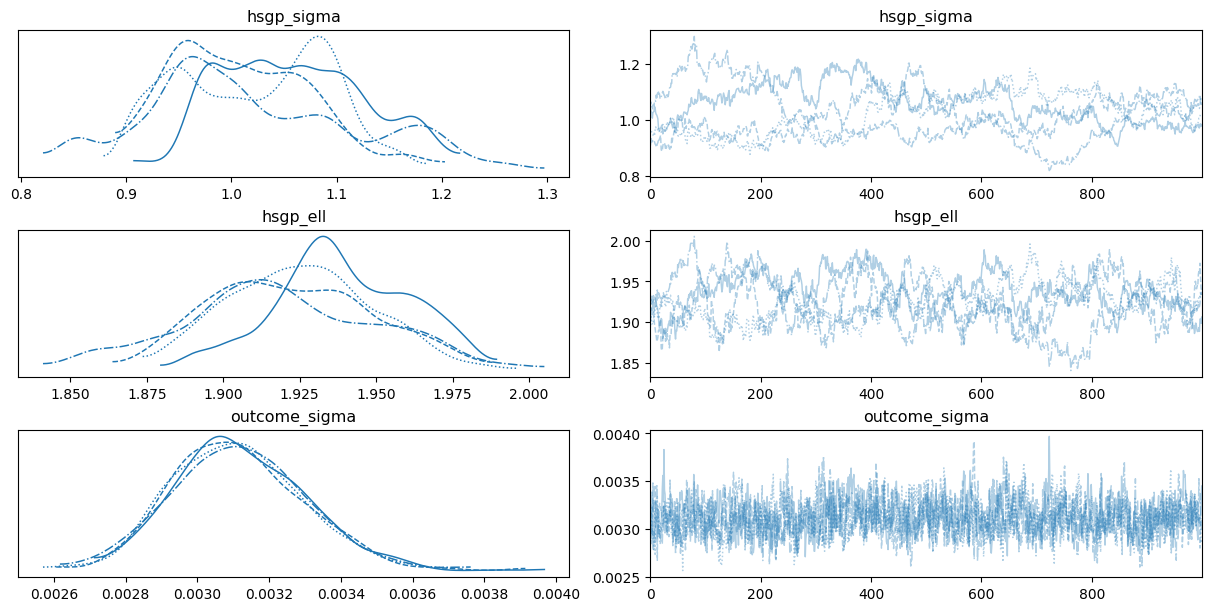

In [12]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - different covariance function

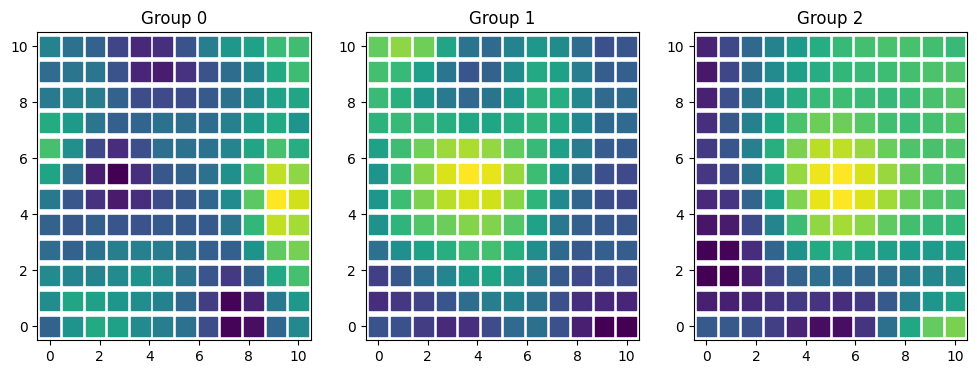

In [13]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [1.5, 2, 3]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [14]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


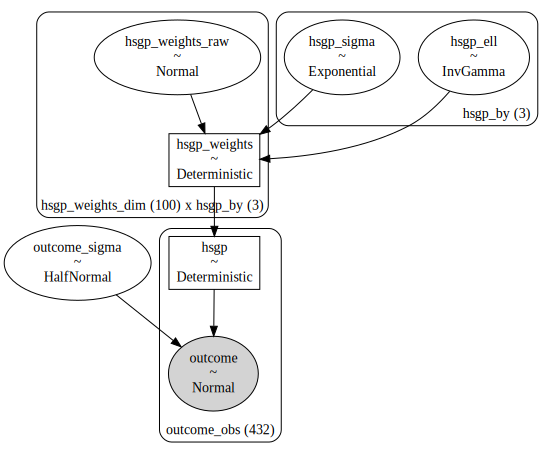

In [15]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, share_cov=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [16]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.792718
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:02:56.443067
Transforming variables...
Transformation time =  0:00:00.644626
0


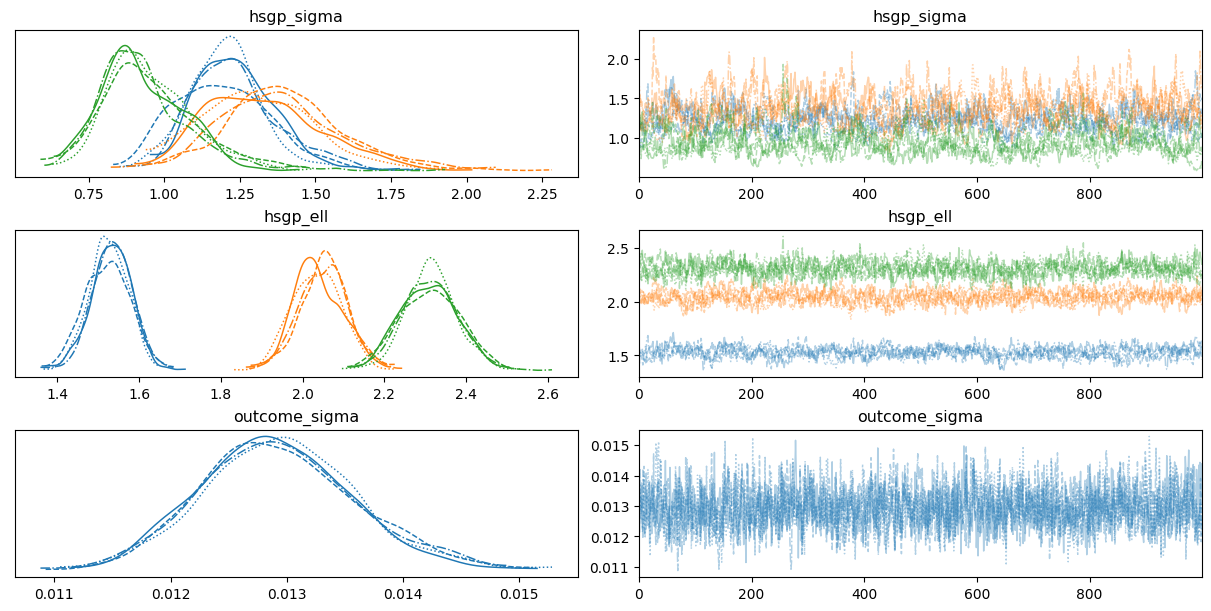

In [17]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

## Anisotropic samples

### A single group

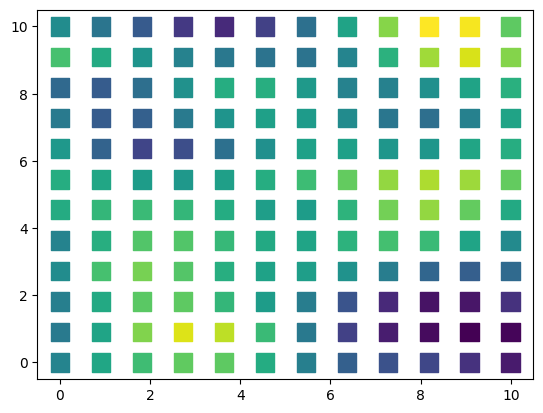

In [18]:
rng = np.random.default_rng(1234)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K)

fig, ax = plt.subplots()
ax.scatter(xx, yy, c=f, s=180, marker="s");

In [19]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 1),
        "y": np.tile(yy.flatten(), 1), 
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, c=1.5, m=10, iso=False)
        Family: gaussian
          Link: mu = identity
  Observations: 144
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, c=1.5, m=10, iso=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


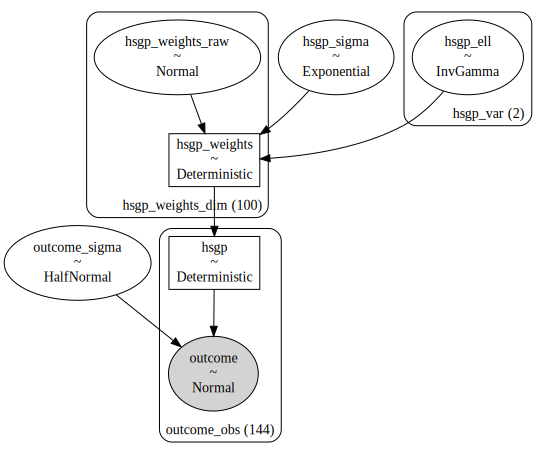

In [20]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, c=1.5, m=10, iso=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [21]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.141034
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.928994
Transforming variables...
Transformation time =  0:00:00.174205
0


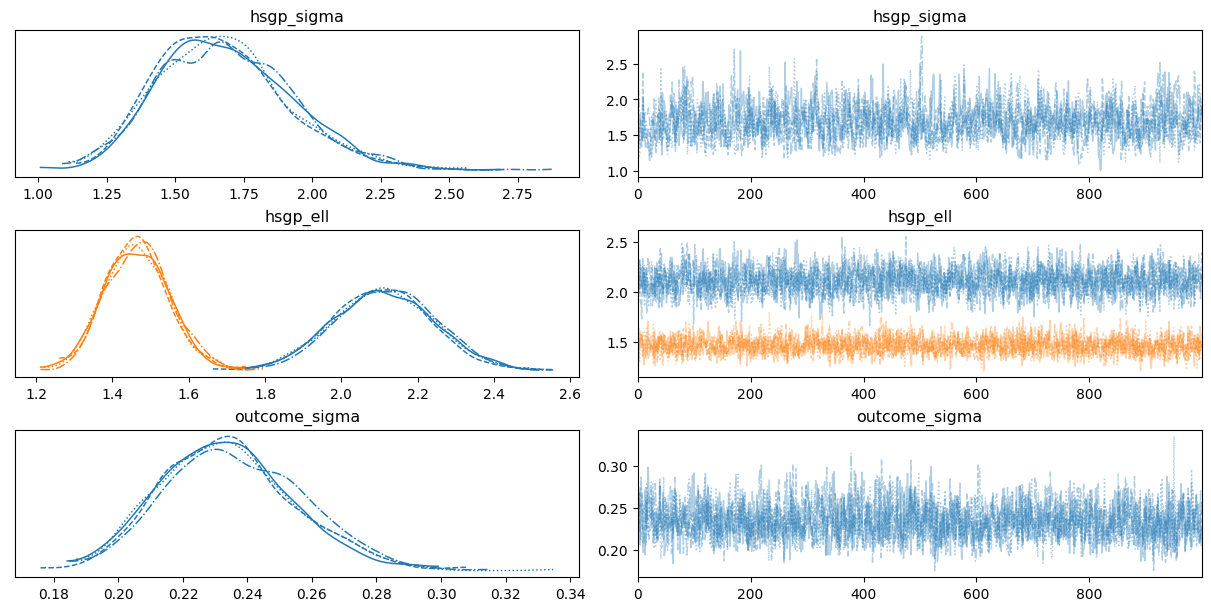

In [22]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - same covariance function

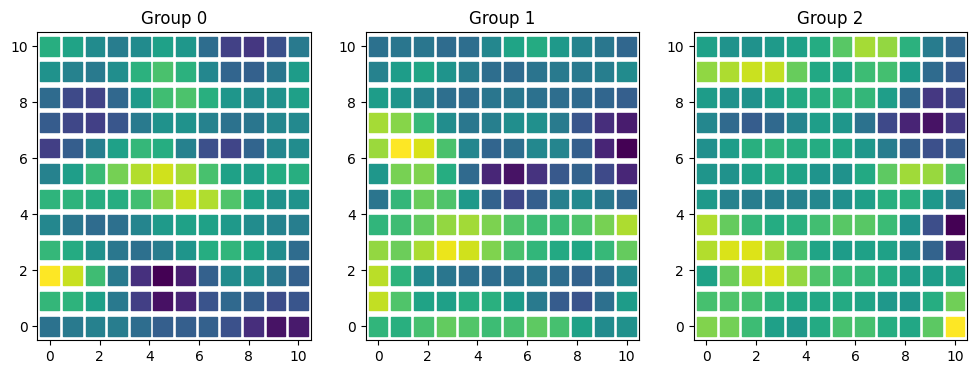

In [23]:
rng = np.random.default_rng(123)

ell = [2, 0.9]
cov = 1.2 * pm.gp.cov.ExpQuad(2, ls=ell)
K = cov(X).eval()
mu = np.zeros(X.shape[0])

f = rng.multivariate_normal(mu, K, 3)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [24]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, iso=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


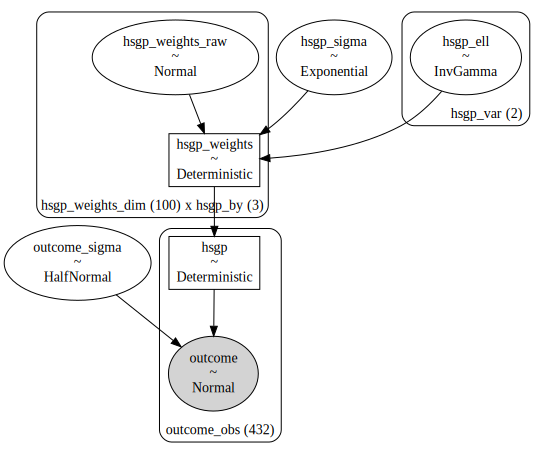

In [25]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model("outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False)", data, priors=priors)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [26]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:02.839460
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:15.927357
Transforming variables...
Transformation time =  0:00:00.250688
0


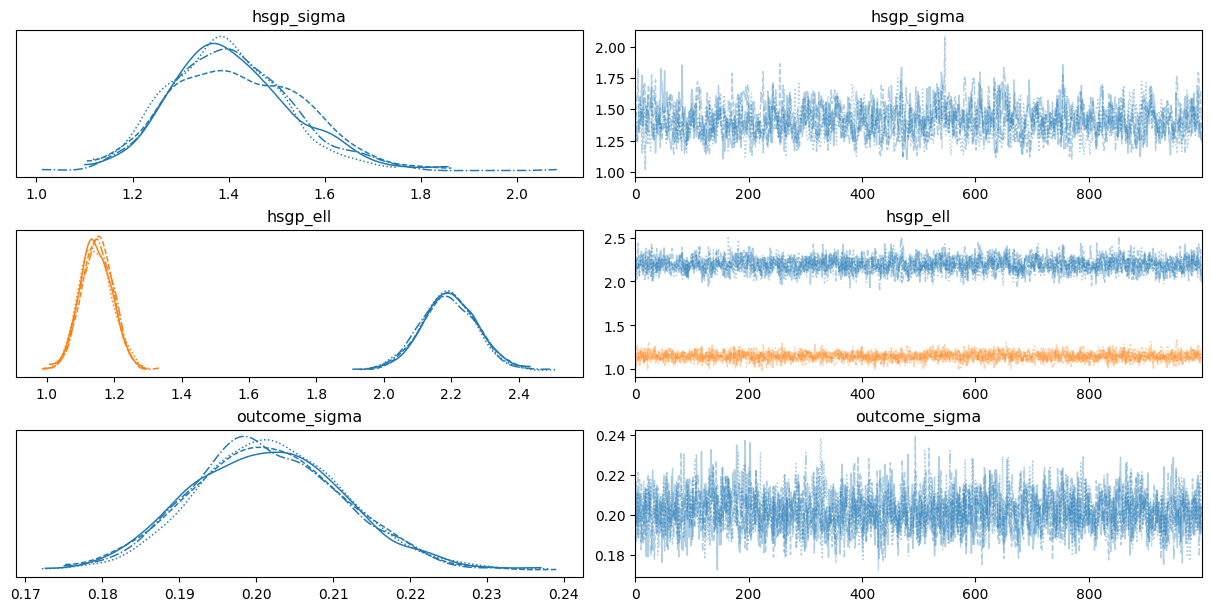

In [27]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

### Multiple groups - different covariance function

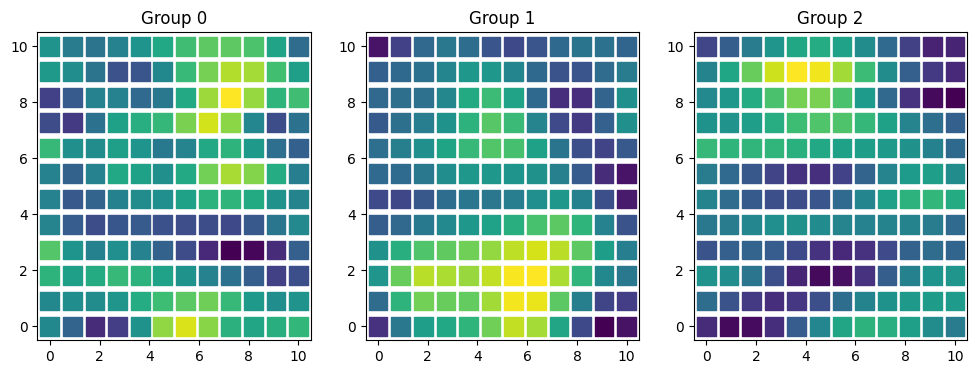

In [28]:
rng = np.random.default_rng(12)

sigmas = [1.2, 1.5, 1.8]
ells = [[1.5, 0.8], [2, 1.5], [3, 1]]

samples = []
for sigma, ell in zip(sigmas, ells):
    cov = sigma * pm.gp.cov.ExpQuad(2, ls=ell)
    K = cov(X).eval()
    mu = np.zeros(X.shape[0])
    samples.append(rng.multivariate_normal(mu, K))

f = np.stack(samples)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.scatter(xx, yy, c=f[i], s=180, marker="s")
    ax.grid(False)
    ax.set_title(f"Group {i}")

In [29]:
data = pd.DataFrame(
    {
        "x": np.tile(xx.flatten(), 3),
        "y": np.tile(yy.flatten(), 3),
        "group": np.repeat(list("ABC"), 12 * 12),
        "outcome": f.flatten()
    }
)

       Formula: outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 432
        Priors: 
    target = mu
        HSGP contributions
            hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)
                cov: ExpQuad
                sigma ~ Exponential(lam: 3.0)
                ell ~ InverseGamma(mu: 2.0, sigma: 0.2)
        
        Auxiliary parameters
            outcome_sigma ~ HalfNormal(sigma: 2.0)


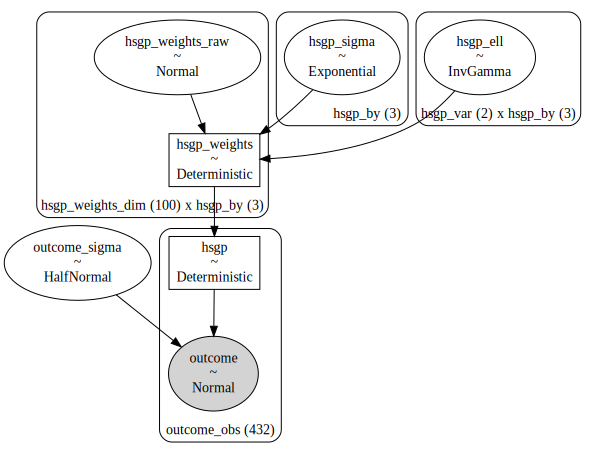

In [30]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.2),
}
priors = {
    "hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": prior_hsgp, 
    "sigma": bmb.Prior("HalfNormal", sigma=2)
}
model = bmb.Model(
    "outcome ~ 0 + hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)", 
    data, 
    priors=priors
)
model.set_alias({"hsgp(x, y, by=group, c=1.5, m=10, iso=False, share_cov=False)": "hsgp"})
print(model)
model.build()
model.graph()

In [31]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.182613
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:22.736571
Transforming variables...
Transformation time =  0:00:00.562768
0


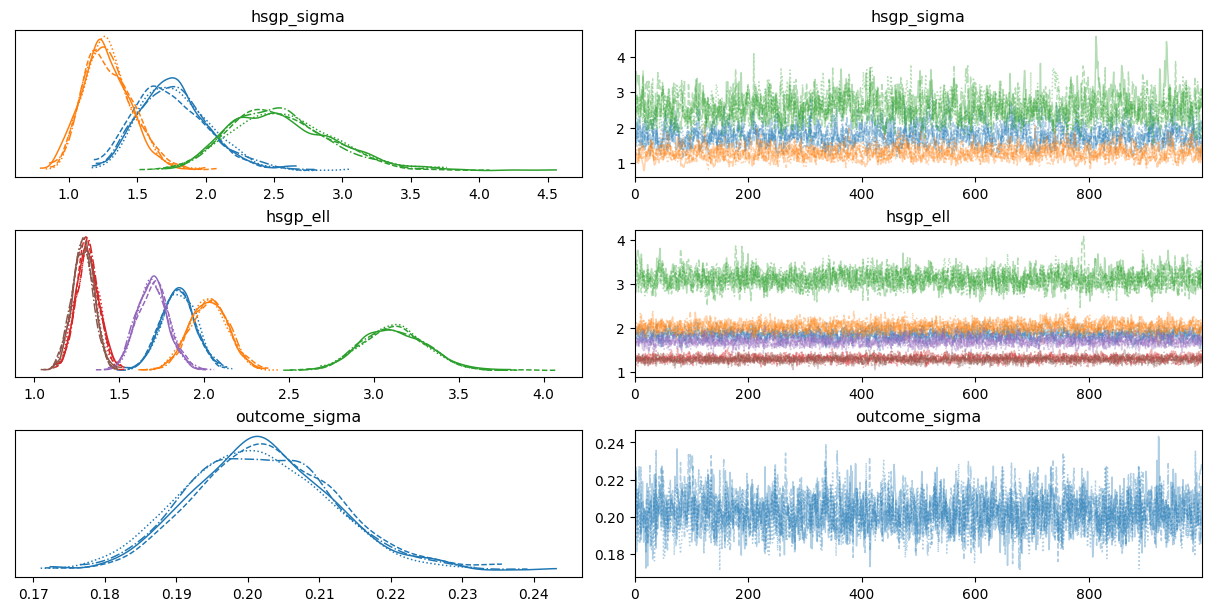

In [32]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "outcome_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

---

In [33]:
data = pd.read_csv("poisson_data.csv")
data["Year"] = pd.Categorical(data["Year"])
data.head()

,Year,Count,Site,Lat,Lon,X1
0,2015,4,Site1,47.559880,7.216754,3.316140
1,2016,0,Site1,47.257079,7.135390,2.249612
2,2015,0,Site1,47.061967,7.804383,2.835283
3,2016,0,Site1,47.385533,7.433145,2.776692
4,2015,1,Site1,47.034987,7.434643,2.295769


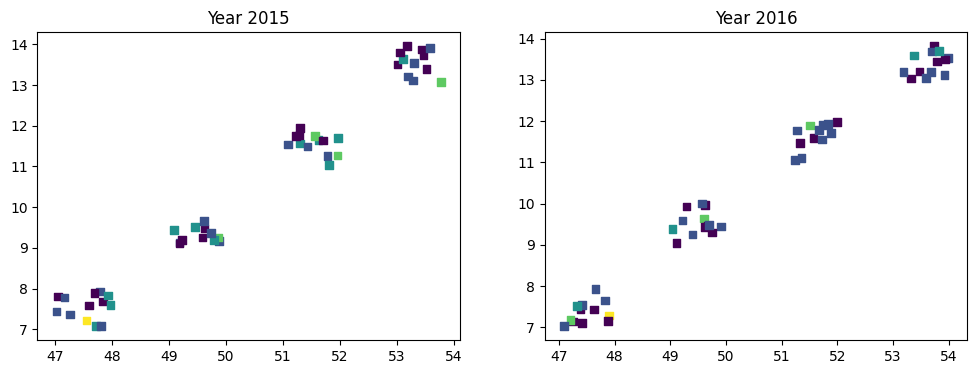

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, (ax, year) in enumerate(zip(axes, [2015, 2016])):
    mask = data["Year"] == year
    x = data.loc[mask, "Lat"]
    y = data.loc[mask, "Lon"]
    count = data.loc[mask, "Count"]
    ax.scatter(x, y, c=count, s=30, marker="s")
    ax.set_title(f"Year {year}")

In [35]:
formula = "Count ~ 0 + Year + X1:Year + (1|Site) + hsgp(Lon, Lat, by=Year, m=8, c=1.5)"
model = bmb.Model(formula, data, family="poisson")
model

       Formula: Count ~ 0 + Year + X1:Year + (1|Site) + hsgp(Lon, Lat, by=Year, m=8, c=1.5)
        Family: poisson
          Link: mu = log
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Year ~ Normal(mu: [0. 0.], sigma: [5. 5.])
            X1:Year ~ Normal(mu: [0. 0.], sigma: [1.5693 1.4766])
        
        Group-level effects
            1|Site ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 5.3683))
        
        HSGP contributions
            hsgp(Lon, Lat, by=Year, m=8, c=1.5)
                cov: ExpQuad
                sigma ~ Exponential(lam: 1.0)
                ell ~ InverseGamma(alpha: 3.0, beta: 2.0)

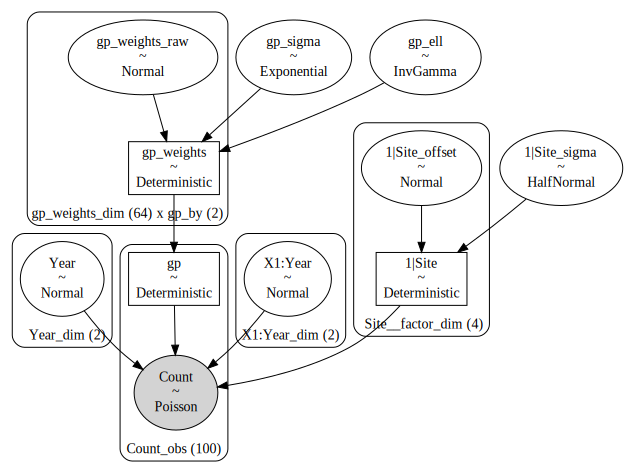

In [36]:
model.set_alias({"hsgp(Lon, Lat, by=Year, m=8, c=1.5)": "gp"})
model.build()
model.graph()

In [37]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.95)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:04.414404
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:08.670807
Transforming variables...
Transformation time =  0:00:00.674187
64


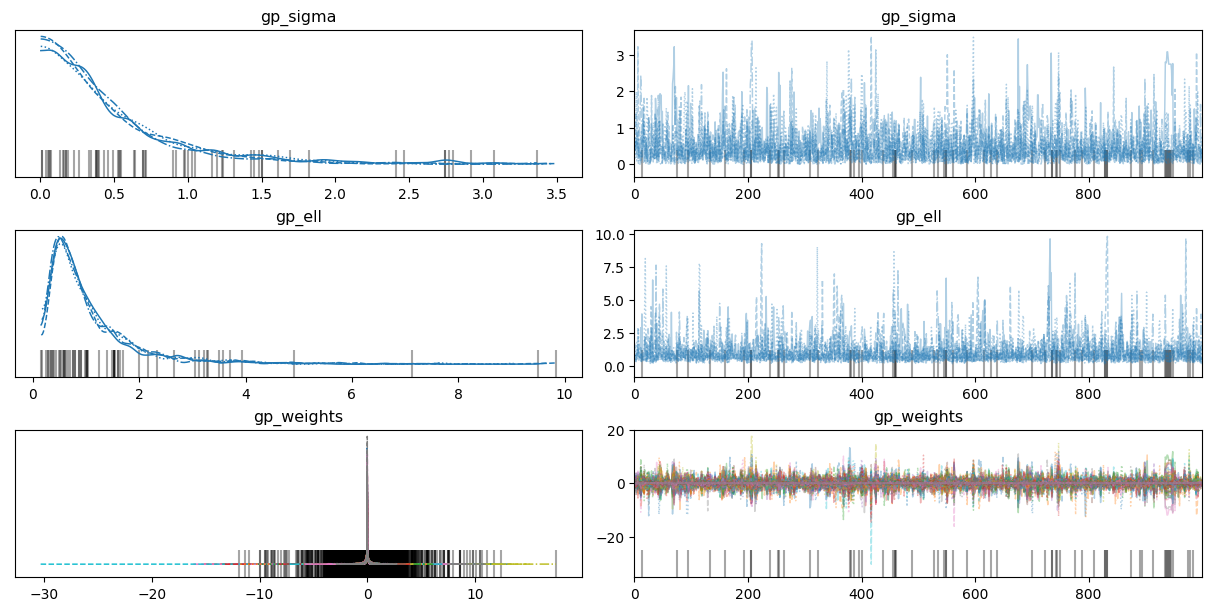

In [38]:
az.plot_trace(
    idata, 
    var_names=["gp_sigma", "gp_ell", "gp_weights"], 
    backend_kwargs={"layout": "constrained"}
);

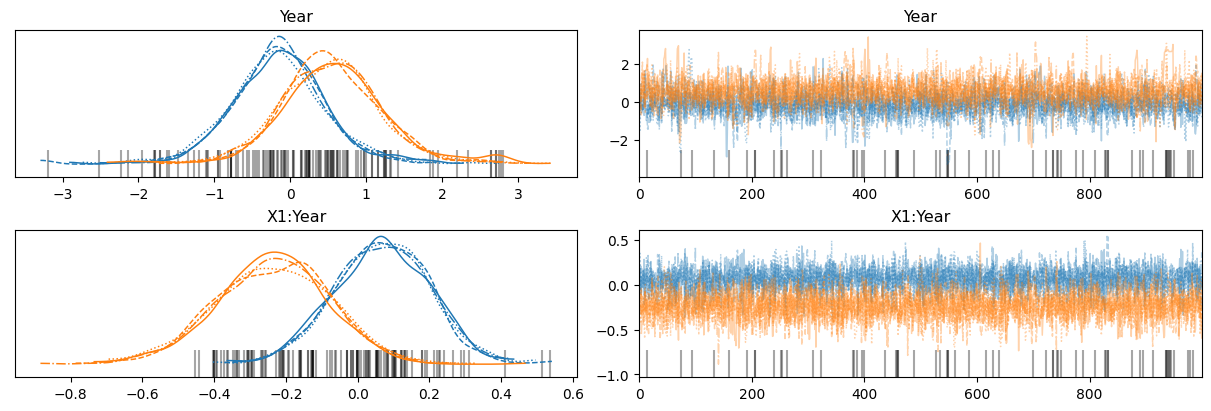

In [39]:
az.plot_trace(
    idata, 
    var_names=["Year", "X1:Year"], 
    backend_kwargs={"layout": "constrained"}
);

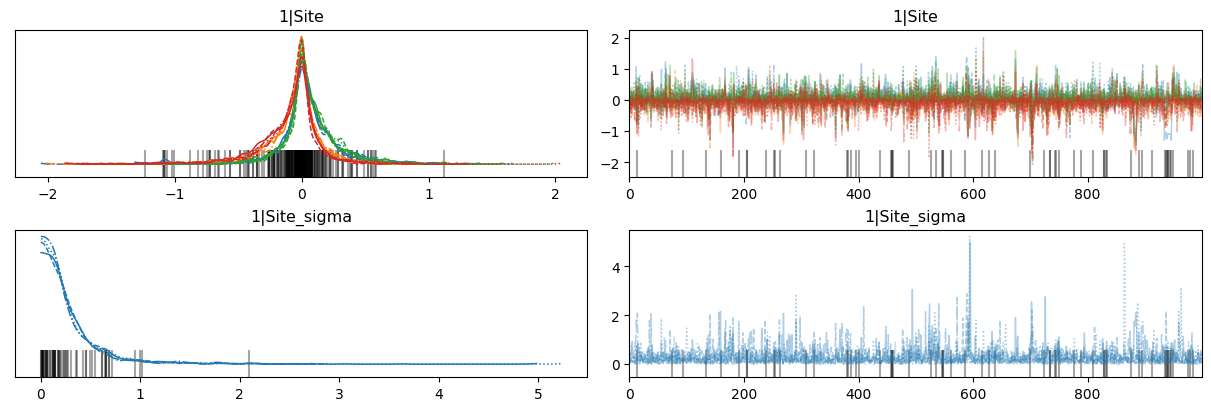

In [40]:
az.plot_trace(
    idata, 
    var_names=["1|Site", "1|Site_sigma"], 
    backend_kwargs={"layout": "constrained"}
);